In [1]:
import sys
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
import genml

sys.path.append('..')
from src.kernels import exp_kernel, complex_exp_kernel, complex_discrete_kernel
from src.probability import Distribution, xi_frac
from src.spectral_transforms import psi_real_to_circle, psi_inv_circle_to_real, B_real, B_circle, B_reg, mobius_inv
from src.numerical import trap_quad, trap_quad_gen, fourier_quad, conv_trap, conv_fourier, volterra_cm_numerical_inversion, volterra_pd_numerical_inversion
from src.plotting import plot_real_distribution, plot_circle_distribution_3D, plot_discrete
from src.hilbert_transform import HilbertTransform

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r"\usepackage{amsfonts}" + "\n" + r"\usepackage{amsmath}" + "\n" + r"\usepackage{amssymb}"
})

In [7]:
t = np.linspace(0, 10, 1000)
dt = t[1] - t[0]

density = lambda s: np.sqrt(s * (s >= 0))/np.pi
atoms = np.array([])
atom_wts = np.array([])
#quad_pts = np.concatenate((np.linspace(-100, 100, int(1e4)), 100 + np.logspace(-1, 5, int(1e4))))
#quad_pts = np.linspace(0, 0.1, int(2e4))
#quad_pts, quad_wts = trap_quad_gen(quad_pts)
#quad_wts *= np.nan
quad_pts, quad_wts = trap_quad(0, 100, int(1e4))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts)
c0 = 0
c1 = 1

xi_frac(lmbda)
mu, zeta0, zeta1 = B_reg(lmbda, c0-np.pi*(1/(np.pi*np.sqrt(2))), c1)

J_spectral = exp_kernel(mu, t) / np.pi**2

alpha = 1/2
a = -1
J = 1/(np.abs(a)*dt**alpha) * genml.acft(len(t)-1, 1, 1, alpha, np.abs(a)**(-1/alpha)/dt)

/Users/georgestepaniants/Research/time-deconvolution/experiments/../src/probability.py:273: RuntimeWarning: invalid value encountered in divide
  res += np.nansum(lmbda.quad_wts*lmbda.density_vals/(lmbda.quad_pts*(1+lmbda.quad_pts**2)))/np.pi


[0.00062832 0.00062832 0.00062832 ... 0.00062832 0.00062832 0.00062832]


In [11]:
xi_frac(lmbda)

0.0

In [34]:
lmbda_circle, c0_circle = psi_real_to_circle(lmbda, 0, 0, len(lmbda.quad_pts), regularized=True)
Hlmbda_circle = HilbertTransform(lmbda_circle)
Hreg = lambda x: Hlmbda_circle(mobius_inv(x))

In [35]:
mobius_inv(0)

0.0

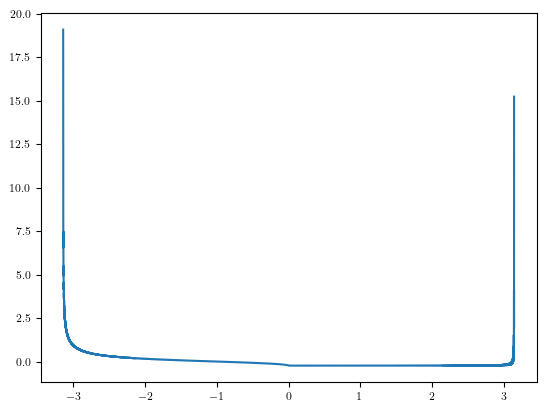

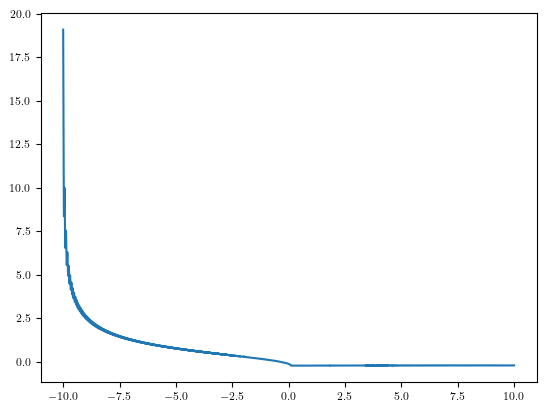

In [36]:
plt.plot(lmbda_circle.quad_pts, Hlmbda_circle(lmbda_circle.quad_pts))
plt.show()

plt.plot(lmbda.quad_pts, Hreg(lmbda.quad_pts))
plt.show()

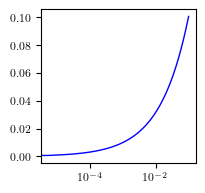

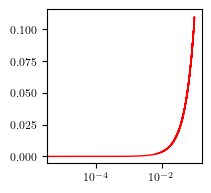

In [18]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_real_distribution(ax, lmbda, color="blue")
plt.xscale("log")
plt.show()

fig, ax = plt.subplots(figsize=(2, 2))
plot_real_distribution(ax, mu, color="red")
plt.xscale("log")
plt.show()

/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_91126/980115280.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(s, np.pi/(s + np.sqrt(s)))


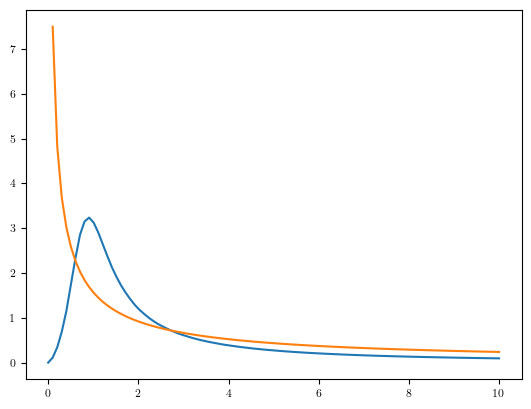

In [12]:
#s = np.concatenate((np.linspace(-100, 100, int(1e4)), 100 + np.logspace(-1, 5, int(1e4))))
s = np.linspace(0, 10, 100)
plt.plot(s, mu.density(s))
plt.plot(s, np.pi/(s + np.sqrt(s)))
#plt.xscale("symlog")
#plt.yscale("log")
plt.show()

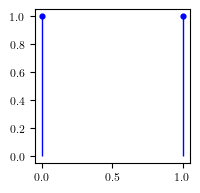

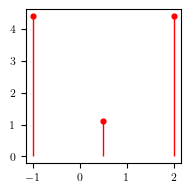

In [2]:
density = None #lambda s: np.sqrt(s * (s >= 0))/np.pi
atoms = np.array([0, 1])
atom_wts = np.array([1, 1])
quad_pts, quad_wts = trap_quad(-1, 2, int(1e3))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts)
c0 = 0
c1 = 1

mu, zeta0, zeta1 = B_reg(lmbda, c0, c1)

fig, ax = plt.subplots(figsize=(2, 2))
plot_real_distribution(ax, lmbda, color="blue")
plt.show()

fig, ax = plt.subplots(figsize=(2, 2))
plot_real_distribution(ax, mu, color="red")
plt.show()

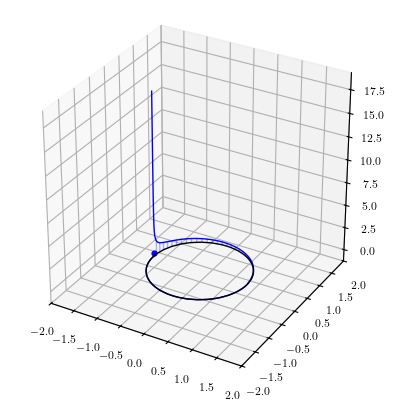

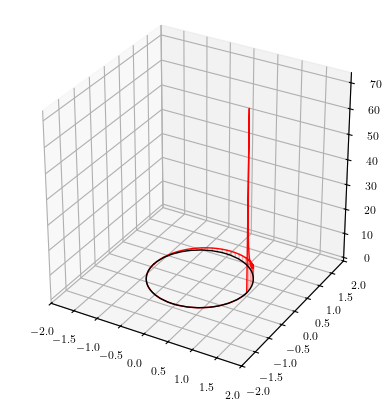

In [3]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot_circle_distribution_3D(ax, lmbda_circle, width = 2, color="blue")
ax.set_box_aspect((1, 1, 1))
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot_circle_distribution_3D(ax, mu_circle, width = 2, color="red")
ax.set_box_aspect((1, 1, 1))
plt.show()

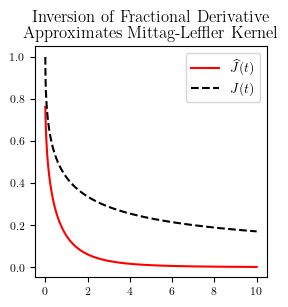

In [8]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(t, J_spectral, color="red", label="$\widehat{J}(t)$")
ax.plot(t, J, color="black", linestyle="--", label="$J(t)$")
ax.set_title("Inversion of Fractional Derivative\n Approximates Mittag-Leffler Kernel", size=12)
plt.legend(fontsize=10)
plt.savefig(f"../figures/fractional_kernel_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

array([0.81709386,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

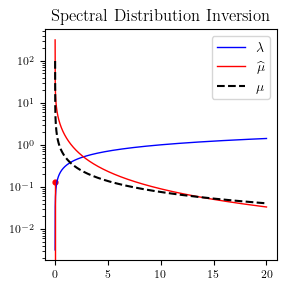

In [48]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_real_distribution(ax, lmbda, color="blue", density_label=f"$\lambda$")
plot_real_distribution(ax, mu, color="red", density_label=f"$\widehat\mu$")
mu_true = lambda s: 1/(s**(1/2) + s)
ax.plot(quad_pts, mu_true(quad_pts), color="black", linestyle="--", label=f"$\mu$")
ax.set_yscale("log")
ax.set_title("Spectral Distribution Inversion", size=12)
plt.legend(fontsize=10)
plt.savefig(f"../figures/fractional_distribution_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

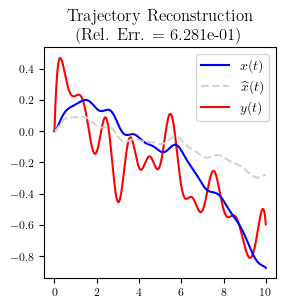

In [47]:
n_interp = 20
np.random.seed(1)
T = t[-1]
interp_ys = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(0, T, n_interp+1)
cs = scipy.interpolate.make_interp_spline(interp_ts, interp_ys, k=5)
y = cs(t)

x = conv_trap(J, y, t)
x_hat = conv_trap(J_spectral, y, t)

rel_err = np.linalg.norm(x_hat - x) / np.linalg.norm(x)

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(t, x, color="blue", zorder=3, label="$x(t)$")
ax.plot(t, x_hat, linestyle='--', zorder=4, color="lightgray", label="$\widehat{x}(t)$")
ax.plot(t, y, color="red", label="$y(t)$")
ax.set_title(f"Trajectory Reconstruction\n(Rel. Err. = {rel_err:.3e})", size=12)
plt.legend(fontsize=10)
plt.savefig(f"../figures/fractional_data_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

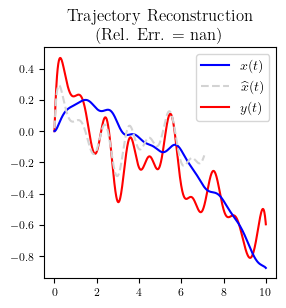

In [44]:
n_interp = 20
np.random.seed(1)
T = t[-1]
interp_ys = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(0, T, n_interp+1)
cs = scipy.interpolate.make_interp_spline(interp_ts, interp_ys, k=5)
y = cs(t)

x = conv_trap(J, y, t)

x_hat = conv_trap(J_spectral, y, t)
x_hat = np.gradient(x_hat, dt)

rel_err = np.linalg.norm(x_hat - x) / np.linalg.norm(x)

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(t, x, color="blue", zorder=3, label="$x(t)$")
ax.plot(t, x_hat, linestyle='--', zorder=4, color="lightgray", label="$\widehat{x}(t)$")
ax.plot(t, y, color="red", label="$y(t)$")
ax.set_title(f"Trajectory Reconstruction\n(Rel. Err. = {rel_err:.3e})", size=12)
plt.legend(fontsize=10)
plt.savefig(f"../figures/fractional_data_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()